In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss

import os, eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp

Using TensorFlow backend.


Get all previous years data form 2009 onward. Using only teams that have made the tourney. 298 of approx. 360 teams have made the tourney in the past 10 years.

In [2]:
df_tourney_all = pd.read_csv('mens-machine-learning-competition-2019/DataFiles/NCAATourneyCompactResults.csv')
df = pd.read_csv('mens-machine-learning-competition-2019/DataFiles/RegularSeasonDetailedResults.csv')
df = df[df.Season > 2008]

#Limit to only tourney teams
past_trny_teams = list(set(list(df_tourney_all.WTeamID.unique()) + list(df_tourney_all.LTeamID.unique()))) 
len(past_trny_teams)

298

Get 2019 tourney teams. Correctly there are 68 teams. Format of submission is an id of 'year'_'team1id'_'team2id' and a predicted probability of team 1 winning. 

To get unique teams split by _ to get both ids, create two sets of lists combine and get unique ids.

In [3]:
df_predict = pd.read_csv('mens-machine-learning-competition-2019/SampleSubmissionStage2.csv')
grp1 = list(set(df_predict.apply(lambda row: row.ID.split('_')[1], axis=1)))
grp2 = list(set(df_predict.apply(lambda row: row.ID.split('_')[2], axis=1)))
crnt_trny_teams = list(set(grp1 + grp2))
len(crnt_trny_teams)

68

Include more descriptive data on the teams involved

In [4]:
#Team name with id, first and last D1 season
df_teams = pd.read_csv('mens-machine-learning-competition-2019/DataFiles/Teams.csv')
#Team name matched with conf abbrev and for each season
df_team_conferences = pd.read_csv('mens-machine-learning-competition-2019/DataFiles/TeamConferences.csv')
#conference abbrev with full name
df_conferences = pd.read_csv('mens-machine-learning-competition-2019/DataFiles/Conferences.csv')

df_conference_names = df_team_conferences.merge(df_conferences, on=['ConfAbbrev'])

#Create tables to use as reference for combining real names with ids for full game results
win_teams = df_teams.rename(columns={'TeamID':'WTeamID'})[['WTeamID', 'TeamName']]
win_confs = df_conference_names.rename(columns={'TeamID':'WTeamID'})[['Season', 'WTeamID', 'Description']]
lose_teams = df_teams.rename(columns={'TeamID':'LTeamID'})[['LTeamID', 'TeamName']]
lose_confs = df_conference_names.rename(columns={'TeamID':'LTeamID'})[['Season', 'LTeamID', 'Description']]

# Merge winning team name and conference, losing team name and conference with season results:
df = df.merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
.merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
.merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
.merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WTeamName,WConfName,LTeamName,LConfName
0,2009,7,1181,80,1342,49,H,0,30,63,3,11,17,21,14,30,13,21,17,4,21,16,53,3,17,14,19,10,19,4,28,5,5,25,Duke,Atlantic Coast Conference,Presbyterian,Big South Conference
1,2009,8,1222,76,1342,57,N,0,30,56,6,15,10,15,8,18,12,9,11,1,23,16,40,6,21,19,24,8,20,8,19,5,3,18,Houston,Conference USA,Presbyterian,Big South Conference
2,2009,25,1155,79,1342,58,H,0,31,58,5,14,12,17,9,29,19,8,10,6,14,23,49,7,20,5,13,5,20,12,15,4,0,17,Clemson,Atlantic Coast Conference,Presbyterian,Big South Conference
3,2009,18,1208,55,1342,47,H,0,25,52,3,7,2,11,11,20,10,13,7,4,16,17,45,6,17,7,10,10,21,10,21,6,4,14,Georgia,Southeastern Conference,Presbyterian,Big South Conference
4,2009,55,1266,84,1342,45,H,0,31,63,9,22,13,16,16,28,23,8,7,3,10,17,47,5,20,6,7,2,18,8,13,5,7,16,Marquette,Big East Conference,Presbyterian,Big South Conference


In [5]:
#Add 2pt fg data
df['WFGM2'] = df.WFGM - df.WFGM3
df['WFGA2'] = df.WFGA - df.WFGA3
df['LFGM2'] = df.LFGM - df.LFGM3
df['LFGA2'] = df.LFGA - df.LFGA3

In [6]:
print('These are the {} conferences that have participated in NCAA Division I men’s basketball since 2009, including the number of wins in the dataframe for each:'.format(len(df.WConfName.value_counts())))
df.WConfName.value_counts()

These are the 35 conferences that have participated in NCAA Division I men’s basketball since 2009, including the number of wins in the dataframe for each:


Atlantic Coast Conference             2645
Big East Conference                   2534
Southeastern Conference               2482
Atlantic 10 Conference                2441
Big Ten Conference                    2439
Big 12 Conference                     2115
Conference USA                        2072
Mid-American Conference               1843
Mountain West Conference              1707
Colonial Athletic Association         1680
Sun Belt Conference                   1671
Missouri Valley Conference            1668
Metro Atlantic Athletic Conference    1620
Pacific-12 Conference                 1563
Ohio Valley Conference                1517
Southern Conference                   1510
Southland Conference                  1484
West Coast Conference                 1464
Northeast Conference                  1458
Horizon League                        1450
Mid-Eastern Athletic Conference       1428
Big Sky Conference                    1353
Big South Conference                  1337
Patriot Lea

In [7]:
print('Season  #Games:')
df.Season.value_counts()

Season  #Games:


2018    5405
2017    5395
2016    5369
2014    5362
2015    5354
2013    5320
2010    5263
2012    5253
2009    5249
2011    5246
Name: Season, dtype: int64

Winning team description of stats

In [8]:
df[['WFGA', 'WFTA', 'WTO', 'WOR', 'WScore', 'WFGM2', 'WFGM3', 'WFGM', 'WFTM', 'WDR', 'WAst', 'WStl', 'WBlk', 'WPF']].describe()

,WFGA,WFTA,WTO,WOR,WScore,WFGM2,WFGM3,WFGM,WFTM,WDR,WAst,WStl,WBlk,WPF
count,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000
mean,55.156720,22.745321,12.520539,10.714334,75.427052,18.949301,7.113932,26.063233,16.186654,25.935245,14.524748,6.769355,3.900838,17.462455
std,7.474602,8.115692,3.879568,4.089870,11.113402,4.644917,3.091733,4.680935,6.252778,4.871046,4.382933,3.013238,2.452969,4.151869
min,27.000000,0.000000,1.000000,0.000000,34.000000,2.000000,0.000000,10.000000,0.000000,8.000000,1.000000,0.000000,0.000000,3.000000
25%,50.000000,17.000000,10.000000,8.000000,68.000000,16.000000,5.000000,23.000000,12.000000,23.000000,11.000000,5.000000,2.000000,15.000000
50%,55.000000,22.000000,12.000000,10.000000,75.000000,19.000000,7.000000,26.000000,16.000000,26.000000,14.000000,6.000000,4.000000,17.000000
75%,60.000000,28.000000,15.000000,13.000000,82.000000,22.000000,9.000000,29.000000,20.000000,29.000000,17.000000,9.000000,5.000000,20.000000
max,103.000000,67.000000,31.000000,38.000000,144.000000,48.000000,26.000000,56.000000,47.000000,53.000000,40.000000,26.000000,18.000000,40.000000


In [9]:
df[['LFGA', 'LFTA', 'LTO', 'LOR', 'LScore', 'LFGM2', 'LFGM3', 'LFGM', 'LFTM', 'LDR', 'LAst', 'LStl', 'LBlk', 'LPF']].describe()

,LFGA,LFTA,LTO,LOR,LScore,LFGM2,LFGM3,LFGM,LFTM,LDR,LAst,LStl,LBlk,LPF
count,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000,53216.000000
mean,56.395313,18.268359,13.775124,10.922241,63.476868,16.529653,6.017871,22.547523,12.363951,21.830765,11.257780,5.838413,2.913353,19.729330
std,7.618530,7.147711,4.212682,4.171806,10.991018,4.296839,2.775566,4.383911,5.389009,4.507210,3.680993,2.687332,2.037197,4.525662
min,29.000000,0.000000,0.000000,0.000000,22.000000,2.000000,0.000000,6.000000,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000
25%,51.000000,13.000000,11.000000,8.000000,56.000000,14.000000,4.000000,20.000000,8.000000,19.000000,9.000000,4.000000,1.000000,17.000000
50%,56.000000,18.000000,13.000000,11.000000,63.000000,16.000000,6.000000,22.000000,12.000000,22.000000,11.000000,6.000000,3.000000,19.000000
75%,61.000000,23.000000,16.000000,14.000000,70.000000,19.000000,8.000000,25.000000,16.000000,25.000000,14.000000,7.000000,4.000000,23.000000
max,106.000000,61.000000,40.000000,36.000000,127.000000,39.000000,20.000000,45.000000,42.000000,49.000000,30.000000,19.000000,17.000000,45.000000


# Create some new stats

In [10]:
# Winner stats related to offensive efficiency:
df['Wposs'] = df.apply(lambda row: row.WFGA + 0.475 * row.WFTA + row.WTO - row.WOR, axis=1)
df['Wshoot_eff'] = df.apply(lambda row: row.WScore / (row.WFGA + 0.475 * row.WFTA), axis=1)
df['Wscore_op'] = df.apply(lambda row: (row.WFGA + 0.475 * row.WFTA) / row.Wposs, axis=1)
df['Woff_rtg'] = df.apply(lambda row: row.WScore/row.Wposs*100, axis=1)

# Loser stats related to offensive efficiency:
df['Lposs'] = df.apply(lambda row: row.LFGA + 0.475 * row.LFTA + row.LTO - row.LOR, axis=1)
df['Lshoot_eff'] = df.apply(lambda row: row.LScore / (row.LFGA + 0.475 * row.LFTA), axis=1)
df['Lscore_op'] = df.apply(lambda row: (row.LFGA + 0.475 * row.LFTA) / row.Lposs, axis=1)
df['Loff_rtg'] = df.apply(lambda row: row.LScore/row.Lposs*100, axis=1)

# Defensive and net efficiency:
df['Wdef_rtg'] = df.apply(lambda row: row.Loff_rtg, axis=1)
df['Wsos'] = df.apply(lambda row: row.Woff_rtg - row.Loff_rtg, axis=1)
df['Ldef_rtg'] = df.apply(lambda row: row.Woff_rtg, axis=1)
df['Lsos'] = df.apply(lambda row: row.Loff_rtg - row.Woff_rtg, axis=1)

# Impact Estimate - 
# First calculate the teams' overall statistical contribution (the numerator):
Wie = df.apply(lambda row: row.WScore + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + (0.5 * row.WOR) + row.WAst + row.WStl + (0.5 * row.WBlk) - row.WPF - row.WTO, axis=1)
Lie = df.apply(lambda row: row.LScore + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + (0.5 * row.LOR) + row.LAst + row.LStl + (0.5 * row.LBlk) - row.LPF - row.LTO, axis=1)

# Then divide by the total game statistics (the denominator):
df['Wie'] = Wie / (Wie + Lie) * 100
df['Lie'] = Lie / (Lie + Wie) * 100

# Other winner stats:
df['Wts_pct'] = df.apply(lambda row: row.WScore / (2 * (row.WFGA + 0.475 * row.WFTA)) * 100, axis=1)
df['Wefg_pct'] = df.apply(lambda row: (row.WFGM2 + 1.5 * row.WFGM3) / row.WFGA, axis=1)
df['Worb_pct'] = df.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
df['Wdrb_pct'] = df.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
df['Wreb_pct'] = df.apply(lambda row: (row.Worb_pct + row.Wdrb_pct) / 2, axis=1)
df['Wto_poss'] = df.apply(lambda row: row.WTO / row.Wposs, axis=1)
df['Wft_rate'] = df.apply(lambda row: row.WFTM / row.WFGA, axis=1)
df['Wast_rtio'] = df.apply(lambda row: row.WAst / (row.WFGA + 0.475*row.WFTA + row.WTO + row.WAst) * 100, axis=1)
df['Wblk_pct'] = df.apply(lambda row: row.WBlk / row.LFGA2 * 100, axis=1)
df['Wstl_pct'] = df.apply(lambda row: row.WStl / row.Lposs * 100, axis=1)
df['W3pta_pct'] = df.apply(lambda row: row.WFGA3 / row.WFGA * 100, axis=1)

# Other loser stats:
df['Lts_pct'] = df.apply(lambda row: row.LScore / (2 * (row.LFGA + 0.475 * row.LFTA)) * 100, axis=1)
df['Lefg_pct'] = df.apply(lambda row: (row.LFGM2 + 1.5 * row.LFGM3) / row.LFGA, axis=1)
df['Lorb_pct'] = df.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
df['Ldrb_pct'] = df.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)
df['Lreb_pct'] = df.apply(lambda row: (row.Lorb_pct + row.Ldrb_pct) / 2, axis=1)
df['Lto_poss'] = df.apply(lambda row: row.LTO / row.Lposs, axis=1)
df['Lft_rate'] = df.apply(lambda row: row.LFTM / row.LFGA, axis=1)
df['Last_rtio'] = df.apply(lambda row: row.LAst / (row.LFGA + 0.475*row.LFTA + row.LTO + row.LAst) * 100, axis=1)
df['Lblk_pct'] = df.apply(lambda row: row.LBlk / row.WFGA2 * 100, axis=1)
df['Lstl_pct'] = df.apply(lambda row: row.LStl / row.Wposs * 100, axis=1)
df['L3pta_pct'] = df.apply(lambda row: row.LFGA3 / row.LFGA * 100, axis=1)

# Calculate weighted factors for winners and losers:
df['Wfour'] = df.apply(lambda row: 0.4*row.Wefg_pct + 0.25*row.Wto_poss + 0.2*row.Worb_pct + 0.15*row.Wft_rate, axis=1)
df['Lfour'] = df.apply(lambda row: 0.4*row.Lefg_pct + 0.25*row.Lto_poss + 0.2*row.Lorb_pct + 0.15*row.Lft_rate, axis=1)

In [11]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WTeamName,WConfName,LTeamName,LConfName,WFGM2,WFGA2,LFGM2,LFGA2,Wposs,Wshoot_eff,Wscore_op,Woff_rtg,Lposs,Lshoot_eff,Lscore_op,Loff_rtg,Wdef_rtg,Wsos,Ldef_rtg,Lsos,Wie,Lie,Wts_pct,Wefg_pct,Worb_pct,Wdrb_pct,Wreb_pct,Wto_poss,Wft_rate,Wast_rtio,Wblk_pct,Wstl_pct,W3pta_pct,Lts_pct,Lefg_pct,Lorb_pct,Ldrb_pct,Lreb_pct,Lto_poss,Lft_rate,Last_rtio,Lblk_pct,Lstl_pct,L3pta_pct,Wfour,Lfour
0,2009,7,1181,80,1342,49,H,0,30,63,3,11,17,21,14,30,13,21,17,4,21,16,53,3,17,14,19,10,19,4,28,5,5,25,Duke,Atlantic Coast Conference,Presbyterian,Big South Conference,27,52,13,36,79.975,1.096266,0.912473,100.031260,80.025,0.790004,0.775070,61.230865,61.230865,38.800394,100.031260,-38.800394,117.647059,-17.647059,54.813292,0.500000,0.424242,0.750000,0.587121,0.262582,0.269841,12.152372,11.111111,21.243361,17.460317,39.500202,0.330189,0.250000,0.575758,0.412879,0.349891,0.264151,4.254188,9.615385,6.251954,32.075472,0.390970,0.309171
1,2009,8,1222,76,1342,57,N,0,30,56,6,15,10,15,8,18,12,9,11,1,23,16,40,6,21,19,24,8,20,8,19,5,3,18,Houston,Conference USA,Presbyterian,Big South Conference,24,41,10,19,64.125,1.203960,0.984405,118.518519,62.400,1.108949,0.823718,91.346154,91.346154,27.172365,118.518519,-27.172365,66.477273,33.522727,60.198020,0.589286,0.285714,0.692308,0.489011,0.140351,0.178571,14.264487,5.263158,17.628205,26.785714,55.447471,0.475000,0.307692,0.714286,0.510989,0.304487,0.475000,10.204082,7.317073,7.797271,52.500000,0.354731,0.398910
2,2009,25,1155,79,1342,58,H,0,31,58,5,14,12,17,9,29,19,8,10,6,14,23,49,7,20,5,13,5,20,12,15,4,0,17,Clemson,Atlantic Coast Conference,Presbyterian,Big South Conference,26,44,16,29,65.075,1.195611,1.015367,121.398386,65.175,1.051201,0.846567,88.991178,88.991178,32.407209,121.398386,-32.407209,74.793388,25.206612,59.780552,0.577586,0.310345,0.852941,0.581643,0.122935,0.206897,20.413645,20.689655,15.343306,24.137931,52.560036,0.540816,0.147059,0.689655,0.418357,0.230150,0.102041,14.602981,0.000000,6.146754,40.816327,0.354872,0.318582
3,2009,18,1208,55,1342,47,H,0,25,52,3,7,2,11,11,20,10,13,7,4,16,17,45,6,17,7,10,10,21,10,21,6,4,14,Georgia,Southeastern Conference,Presbyterian,Big South Conference,22,45,11,28,59.225,0.961118,0.966230,92.866188,60.750,0.944724,0.818930,77.366255,77.366255,15.499933,92.866188,-15.499933,57.983193,42.016807,48.055920,0.509615,0.343750,0.666667,0.505208,0.219502,0.038462,12.464942,14.285714,11.522634,13.461538,47.236181,0.444444,0.333333,0.656250,0.494792,0.345679,0.155556,12.383901,8.888889,10.130857,37.777778,0.333241,0.354198
4,2009,55,1266,84,1342,45,H,0,31,63,9,22,13,16,16,28,23,8,7,3,10,17,47,5,20,6,7,2,18,8,13,5,7,16,Marquette,Big East Conference,Presbyterian,Big South Conference,22,41,12,27,62.600,1.189802,1.127796,134.185304,61.325,0.894188,0.820628,73.379535,73.379535,60.805768,134.185304,-60.805768,82.773109,17.226891,59.490085,0.563492,0.470588,0.933333,0.701961,0.127796,0.206349,22.637795,11.111111,11.414594,34.920635,44.709389,0.414894,0.066667,0.529412,0.298039,0.211985,0.127660,11.216264,17.073171,7.987220,42.553191,0.382416,0.251436
5,2009,50,1376,75,1342,56,H,0,32,55,3,12,8,13,7,22,13,11,7,3,12,22,51,5,19,7,11,10,18,12,16,4,2,18,South Carolina,Southeastern Conference,Presbyterian,Big South Conference,29,43,17,32,65.175,1.225991,0.938627,115.074799,62.225,0.995998,0.903576,89.995982,89.995982,25.078816,115.074799,-25.078816,71.000000,29.000000,61.299550,0.609091,0.280000,0.687500,0.483750,0.168776,0.145455,15.262694,9.375000,11.249498,21.818182,49.799911,0.480392,0.312500,0.720000,0.516250,0.257131,0.137255,14.247551,4.651163,6.137323,37.254902,0.363649,0.339528
6,2009,70,1440,90,1342,75,H,0,28,71,12,42,22,29,15,18,14,10,14,5,19,27,58,4,19,17,25,19,31,14,23,3,5,22,VMI,Big South Conference,Presbyterian,Big South Conference,16,29,23,39,79.775,1.061634,1.062676,112.817299,73.875,1.073345,0.945854

## Calculate Season Averages

In [12]:
# Initialize dataframe to hold season averages:
df_avgs = pd.DataFrame()

# Get and save number of wins and losses:
df_avgs['n_wins'] = df['WTeamID'].groupby([df.Season, df.WTeamID, df.WTeamName, df.WConfName]).count()
df_avgs['n_loss'] = df['LTeamID'].groupby([df.Season, df.LTeamID, df.LTeamName, df.LConfName]).count()

df_avgs['n_loss'].fillna(0, inplace=True)
# Calculate win percentages:
df_avgs['win_pct'] = df_avgs['n_wins'] / (df_avgs['n_wins'] + df_avgs['n_loss'])  

In [13]:
def calc_avg(var):
    df_avgs['W' + var] = df['W' + var].groupby([df['Season'], df['WTeamID'], df.WTeamName, df.WConfName]).mean()
    df_avgs['L' + var] = df['L' + var].groupby([df['Season'], df['LTeamID'], df.LTeamName, df.LConfName]).mean()
    df_avgs[var] = df_avgs['W' + var] * df_avgs['win_pct'] + df_avgs['L' + var] * (1 - df_avgs['win_pct'])
    
    

In [14]:
# Calculate averages for games won:
stats = ['shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ts_pct', 'efg_pct', 'orb_pct','drb_pct', 'reb_pct',
        'to_poss', 'ft_rate', 'ie', 'ast_rtio', 'blk_pct', 'stl_pct', '3pta_pct', 'four']
for stat in stats:
    calc_avg(stat)

In [15]:
df_avgs.reset_index(inplace = True)
df_avgs = df_avgs.rename(columns={'WTeamID': 'TeamID', 'WTeamName': 'TeamName', 'WConfName': 'ConfName'})
df_avgs.head()

,Season,TeamID,TeamName,ConfName,n_wins,n_loss,win_pct,Wshoot_eff,Lshoot_eff,shoot_eff,Wscore_op,Lscore_op,score_op,Woff_rtg,Loff_rtg,off_rtg,Wdef_rtg,Ldef_rtg,def_rtg,Wsos,Lsos,sos,Wts_pct,Lts_pct,ts_pct,Wefg_pct,Lefg_pct,efg_pct,Worb_pct,Lorb_pct,orb_pct,Wdrb_pct,Ldrb_pct,drb_pct,Wreb_pct,Lreb_pct,reb_pct,Wto_poss,Lto_poss,to_poss,Wft_rate,Lft_rate,ft_rate,Wie,Lie,ie,Wast_rtio,Last_rtio,ast_rtio,Wblk_pct,Lblk_pct,blk_pct,Wstl_pct,Lstl_pct,stl_pct,W3pta_pct,L3pta_pct,3pta_pct,Wfour,Lfour,four
0,2009,1102,Air Force,Mountain West Conference,8,21.0,0.275862,1.242686,1.025332,1.085291,0.923620,0.877024,0.889878,114.455328,89.383663,96.299984,87.390393,111.138858,104.587557,27.064935,-21.755195,-8.287573,62.134297,51.266582,54.264573,0.595616,0.478740,0.510982,0.341141,0.208193,0.244868,0.693397,0.709906,0.705352,0.517269,0.459049,0.475110,0.223467,0.228906,0.227405,0.359318,0.266818,0.292335,75.177725,33.528357,45.017838,17.695210,14.014219,15.029665,8.126265,8.481991,8.383859,11.437155,7.231943,8.392002,34.313865,42.582304,40.301355,0.416239,0.330384,0.354068
1,2009,1103,Akron,Mid-American Conference,22,12.0,0.647059,1.076225,0.991945,1.046479,0.992331,0.926358,0.969046,106.413878,91.460344,101.136160,84.156257,105.517619,91.695561,22.257621,-14.057275,9.440599,53.811238,49.597240,52.323944,0.499803,0.456865,0.484648,0.355180,0.307021,0.338182,0.674714,0.575722,0.639775,0.514947,0.441371,0.488979,0.195263,0.234039,0.208949,0.293523,0.222251,0.268368,71.083870,33.341320,57.762970,13.937270,12.398048,13.394015,7.364288,5.646327,6.757949,12.869910,8.973926,11.494857,39.769152,39.206328,39.570508,0.363801,0.335998,0.353988
2,2009,1104,Alabama,Southeastern Conference,16,14.0,0.533333,1.095082,0.972428,1.037844,0.988342,0.994857,0.991382,108.022714,96.570564,102.678377,91.519224,110.386616,100.324007,16.503490,-13.816051,2.354371,54.754118,48.621390,51.892178,0.506259,0.444498,0.477437,0.407969,0.357192,0.384273,0.649835,0.628905,0.640067,0.528902,0.493048,0.512170,0.213900,0.201732,0.208222,0.294686,0.253986,0.275692,65.618452,39.006635,53.199604,12.616103,10.206345,11.491549,11.674855,11.171484,11.439949,10.394757,9.200324,9.837355,23.924501,25.130558,24.487328,0.381775,0.337768,0.361239
3,2009,1105,Alabama A&M,Southwest Athletic Conference,7,17.0,0.291667,1.059991,0.898415,0.945542,0.943322,0.949432,0.947650,98.473000,85.092437,88.995102,86.224968,104.928114,99.473030,12.248032,-19.835676,-10.477928,52.999556,44.920761,47.277077,0.507842,0.402114,0.432951,0.308921,0.308077,0.308323,0.610367,0.631655,0.625446,0.459644,0.469866,0.466884,0.216721,0.225687,0.223072,0.261999,0.275073,0.271259,63.484597,28.028831,38.370096,15.230724,9.292810,11.024702,9.382696,7.437214,8.004646,13.531301,10.061482,11.073513,31.356311,28.494130,29.328933,0.358401,0.320143,0.331302
4,2009,1106,Alabama St,Southwest Athletic Conference,20,9.0,0.689655,1.114374,1.006277,1.080827,0.971961,0.959376,0.968056,107.667544,96.617989,104.238372,88.434221,110.462401,95.270553,19.233322,-13.844412,8.967819,55.718715,50.313834,54.041338,0.535062,0.479269,0.517747,0.348021,0.333203,0.343423,0.661622,0.614641,0.647042,0.504822,0.473922,0.495232,0.200313,0.215860,0.205138,0.261447,0.186299,0.238125,69.750162,38.975763,60.199487,15.571216,13.909781,15.055598,12.136789,8.700870,11.070469,8.569670,8.733183,8.620415,29.203078,36.378297,31.429870,0.372924,0.340258,0.362786


# Explore!

In [16]:
def tourn_round(DayNum):
    """
    Consolidate tournament rounds into meaningful info.
    """
    if (DayNum == 136) | (DayNum == 137):
        return 64
    elif (DayNum == 138) | (DayNum == 139):
        return 32
    elif (DayNum == 143) | (DayNum == 144):
        return 16
    elif (DayNum == 145) | (DayNum == 146):
        return 8
    elif DayNum == 152:
        return 4
    elif DayNum == 154:
        return 2
    else:
        return 68
    
df_tourney_all['tourn_round'] = df_tourney_all.DayNum.apply(tourn_round)

In [17]:
df_seeds = pd.read_csv('mens-machine-learning-competition-2019/DataFiles/NCAATourneySeeds.csv')

# Get the seed number by taking the last two characters of 'Seed' values:
df_seeds['seed'] = df_seeds['Seed'].apply(lambda x : int(x[1:3]))
df_seeds.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [18]:
# Drop the old 'Seed' column:
df_seeds = df_seeds[['Season', 'TeamID', 'seed']]

# Merge seeds, team names, and conference names with tournament data:
df_tourney_all = df_tourney_all.merge(df_seeds, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']) \
.rename(columns={'seed': 'Wseed'}).drop(['TeamID'], axis=1) \
.merge(df_seeds, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']) \
.rename(columns={'seed': 'Lseed'}).drop(['TeamID'], axis=1) \
.merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
.merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
.merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
.merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})

# Calculate the point differential:
df_tourney_all['point_diff'] = df_tourney_all.WScore - df_tourney_all.LScore

In [19]:
df_tourney_all

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round,Wseed,Lseed,WTeamName,WConfName,LTeamName,LConfName,point_diff
0,1985,136,1116,63,1234,54,N,0,64,9,8,Arkansas,Southwest Conference,Iowa,Big Ten Conference,9
1,1997,138,1246,75,1234,69,N,0,32,1,8,Kentucky,Southeastern Conference,Iowa,Big Ten Conference,6
2,2001,138,1246,92,1234,79,N,0,32,2,7,Kentucky,Southeastern Conference,Iowa,Big Ten Conference,13
3,1987,146,1424,84,1234,81,N,0,8,1,2,UNLV,Pacific Coast Athletic Association,Iowa,Big Ten Conference,3
4,1991,138,1181,85,1234,70,N,0,32,2,7,Duke,Atlantic Coast Conference,Iowa,Big Ten Conference,15
5,1992,138,1181,75,1234,62,N,0,32,1,9,Duke,Atlantic Coast Conference,Iowa,Big Ten Conference,13
6,1986,137,1301,66,1234,64,N,0,64,6,11,NC State,Atlantic Coast Conference,Iowa,Big Ten Conference,2
7,1989,139,1301,102,1234,96,N,1,32,5,4,NC State,Atlantic Coast Conference,Iowa,Big Ten Conference,6
8,2016,139,1437,87,1234,68,N,0,32,2,7,Villanova,Big East Conference,Iowa,Big Ten Conference,19
9,1988,144,1112,99,1234,79,N,0,16,1,5,Arizona,Pacific-10 Conference,Iowa,Big Ten Conference,20


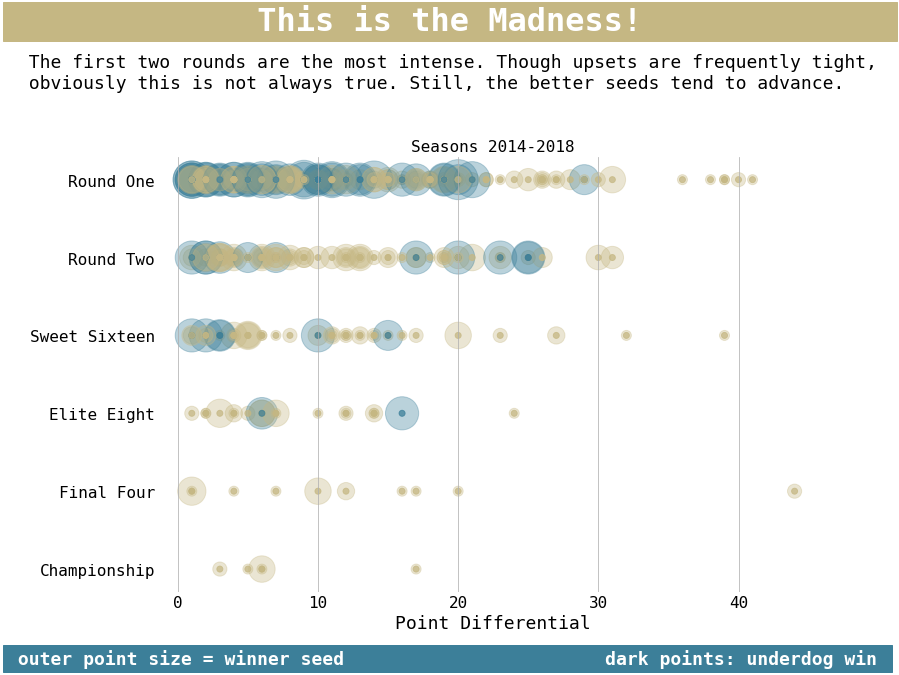

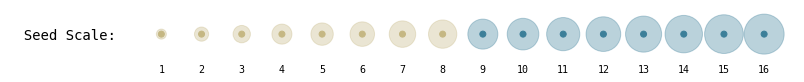

In [20]:
def plot_seed_scale():
    """
    Plot a scale reference of how seeds are represented in this notebook.
    """
    # Save list of seed integers:
    seeds = np.arange(16)+1
    
    # Set scatter points to the first color if the winning seed >8, otherwise set it to the second color:
    colors = np.where(seeds > 8, '#3c7f99', '#c5b783')
    
    # Scale the point sizes to reflect winning seed:
    point_size = seeds*100

    fig, ax = plt.subplots(figsize=(12, 1))
    plt.scatter(x=seeds, y=np.zeros(len(seeds), dtype=int), color=colors, alpha=0.35, s=point_size)
    plt.scatter(x=seeds, y=np.zeros(len(seeds), dtype=int), color=colors)
    plt.box(False)

    # Showw all of the xticks and only one ytick:
    plt.xticks(seeds), plt.yticks(np.arange(1), (''))

    # Set the ylabel:
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = '  Seed Scale: '
    ax.set_yticklabels(labels, fontsize=14)

    # Remove tick marks:
    plt.tick_params(axis='both', which='both',length=0)

# Save a dataframe of the last 5 years and only games between the final 64 tournament teams:
madness = df_tourney_all[(df_tourney_all.Season >= 2014) & (df_tourney_all.tourn_round <= 64)]
madness.sort_values(by='tourn_round', ascending=False, inplace=True)

# Set scatter points to the first color if the winning seed >8, otherwise set it to the second color:
colors = np.where(madness.Wseed > 8, '#3c7f99', '#c5b783')

# Scale the point sizes to reflect winning seed:
point_size = madness.Wseed*100

rounds = ('Round One', 'Round Two', 'Sweet Sixteen', 'Elite Eight', 'Final Four', 'Championship')

# Plot point differential by round, using color and size to reveal winning seed characteristics:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(madness.point_diff, madness.tourn_round.astype(str), color=colors, alpha=0.35, s=point_size)
plt.scatter(madness.point_diff, madness.tourn_round.astype(str), color=colors, alpha=0.75)
plt.box(False) # get rid of border

# Titles and subtitles:
fig.text(x=-0.05, y=1.1, s='             This is the Madness!             ', fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
fig.text(x=-0.05, y=1, s='  The first two rounds are the most intense. Though upsets are frequently tight, \n  obviously this is not always true. Still, the better seeds tend to advance.', fontsize=18)
plt.title('Seasons 2014-2018', fontsize=16)

# Reverse the y-axis to reflect tournament progression:
plt.ylim(plt.ylim()[::-1])

# Tick marks and labels, x-axis label -
# Get rid of tick marks:
plt.tick_params(axis='both', which='both', length=0)

# Set tick label font size:
plt.tick_params(axis='both', which='major', labelsize=16)

# Label y-ticks according to tourney round:
plt.yticks(np.arange(len(rounds)), rounds)

# Label x-axis and show grid lines:
ax.xaxis.grid(which='both', linewidth=0.75)
plt.xlabel('Point Differential', fontsize=18)

# Add an info bar at the bottom:
fig.text(x=-0.05, y=0, s=' outer point size = winner seed                        dark points: underdog win ', fontsize=18, weight='bold', color='white', backgroundcolor='#3c7f99')

# Show the full scale of winning seed representation:
plot_seed_scale();

In [21]:
# Championship game statistics for 2014 - 2018:
df_tourney_all[(df_tourney_all.Season >= 2014) & (df_tourney_all.tourn_round == 2)].sort_values(by='Season')

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round,Wseed,Lseed,WTeamName,WConfName,LTeamName,LConfName,point_diff
1139,2014,154,1163,60,1246,54,N,0,2,7,8,Connecticut,American Athletic Conference,Kentucky,Southeastern Conference,6
1464,2015,154,1181,68,1458,63,N,0,2,1,1,Duke,Atlantic Coast Conference,Wisconsin,Big Ten Conference,5
54,2016,154,1437,77,1314,74,N,0,2,2,1,Villanova,Big East Conference,North Carolina,Atlantic Coast Conference,3
1711,2017,154,1314,71,1211,65,N,0,2,1,1,North Carolina,Atlantic Coast Conference,Gonzaga,West Coast Conference,6
205,2018,154,1437,79,1276,62,N,0,2,1,3,Villanova,Big East Conference,Michigan,Big Ten Conference,17


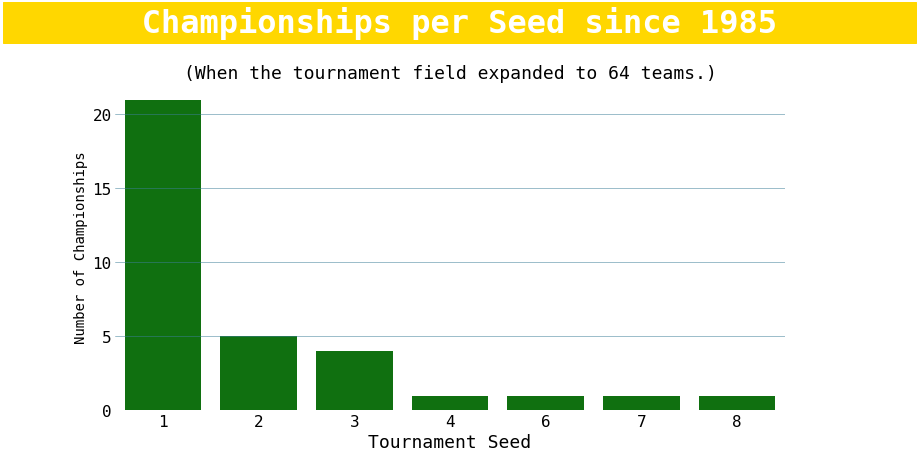

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x=df_tourney_all[df_tourney_all.tourn_round == 2].Wseed, color='green')
plt.box(False)

fig.text(x=0, y=1, s='       Championships per Seed since 1985       ', fontsize=32, weight='bold', color='white', backgroundcolor='#FFD700')
plt.title('(When the tournament field expanded to 64 teams.)', fontsize=18)

ax.yaxis.set_major_locator(MaxNLocator(integer=True, steps=[1, 2, 5, 10]))
ax.yaxis.grid(which='both', linewidth=0.5, color='#3c7f99')

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Championships', fontsize=14), plt.xlabel('Tournament Seed', fontsize=18);

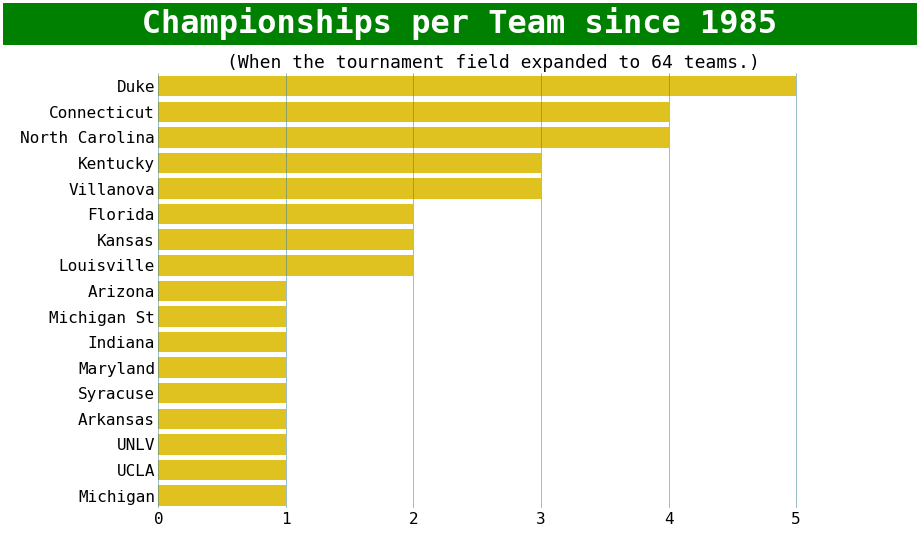

In [23]:
championships = df_tourney_all[df_tourney_all.tourn_round == 2]

fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(y=championships.WTeamName, order=championships.WTeamName.value_counts().index, color='#FFD700')
plt.box(False)

fig.text(x=-0.05, y=0.95, s='       Championships per Team since 1985       ', fontsize=32, weight='bold', color='white', backgroundcolor='green')
plt.title('(When the tournament field expanded to 64 teams.)', fontsize=18)

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel(''), plt.ylabel('');

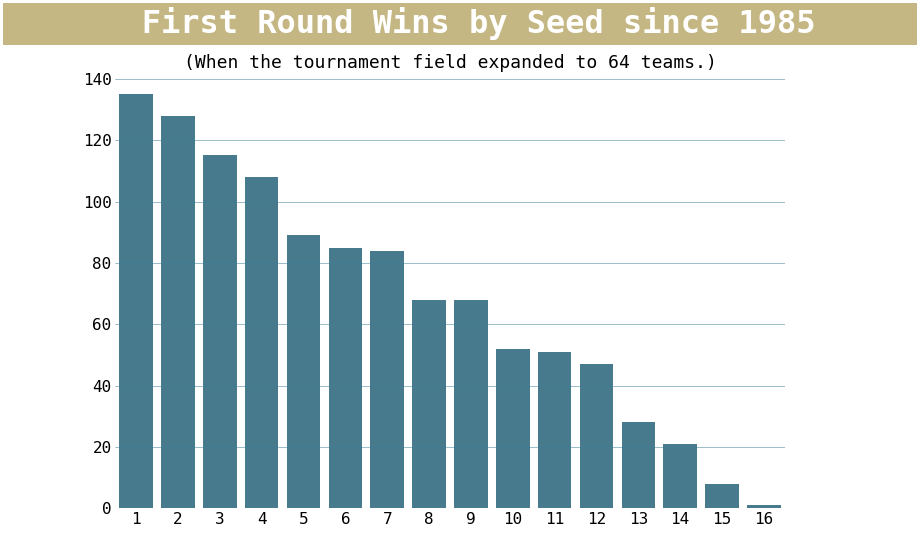

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x=df_tourney_all[df_tourney_all.tourn_round == 64].Wseed, color='#3c7f99')
plt.box(False)

fig.text(x=0, y=0.95, s='       First Round Wins by Seed since 1985     ', fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
plt.title('(When the tournament field expanded to 64 teams.)', fontsize=18)

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel(''), plt.ylabel('');

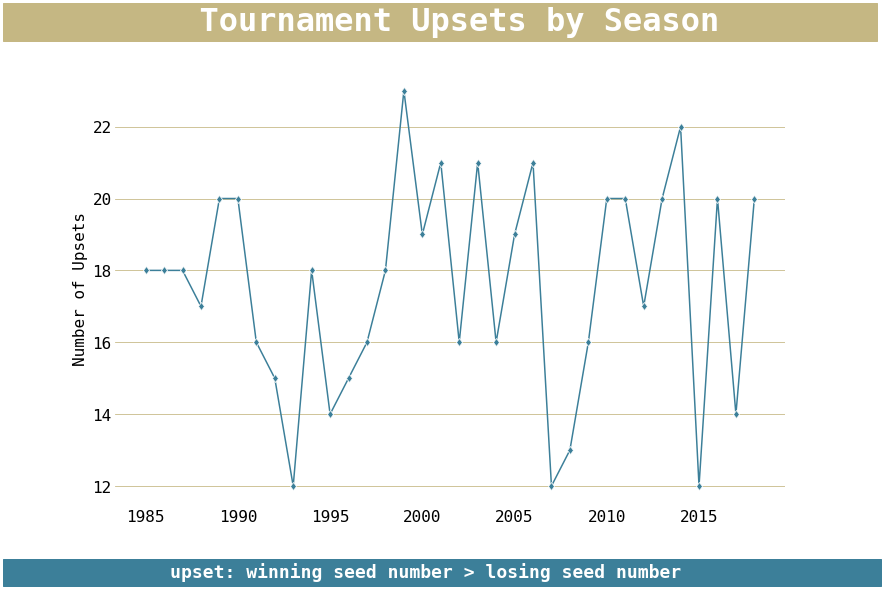

In [25]:
upsets = df_tourney_all[df_tourney_all.Wseed > df_tourney_all.Lseed]
upset_counts = upsets.groupby(['Season'], as_index=False).Wseed.count().rename(columns={'Wseed': 'upset_count'})

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=upset_counts.Season, y=upset_counts.upset_count, marker='d', color='#3c7f99')
plt.box(False)

fig.text(x=0, y=0.95, s='          Tournament Upsets by Season        ', fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.grid(which='both', color='#c5b783')
plt.xlabel(''), plt.ylabel('Number of Upsets', fontsize=16)

# Add an info bar at the bottom:
fig.text(x=0, y=0, s='               upset: winning seed number > losing seed number                  ', fontsize=18, weight='bold', color='white', backgroundcolor='#3c7f99');

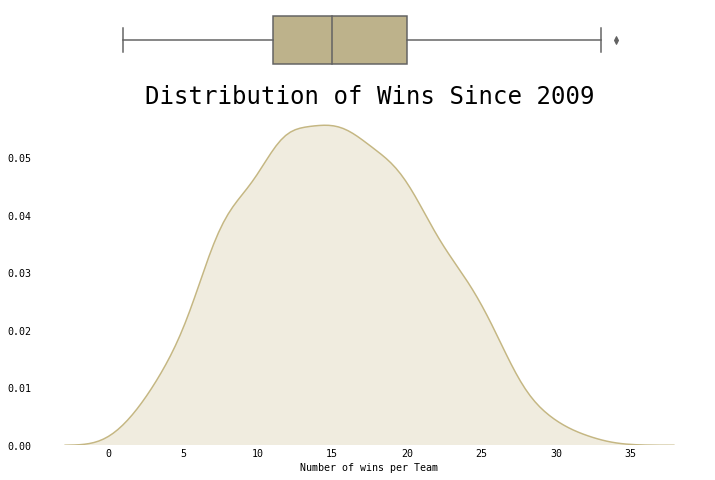

In [26]:
sns.set_style({'xtick.bottom': False, 'ytick.left': False})
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, figsize=(12, 8), gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(df_avgs.n_wins, ax=boxplot, color='#c5b783')
sns.despine(left=True, bottom=True)
boxplot.set(xlabel='')


sns.kdeplot(df_avgs.n_wins, shade=True, ax=histogram, legend=False, color='#c5b783')
plt.box(False)
plt.title('Distribution of Wins Since 2009', fontsize=24)
plt.xlabel('Number of wins per Team')
plt.tick_params(axis='both', which='both',length=0);

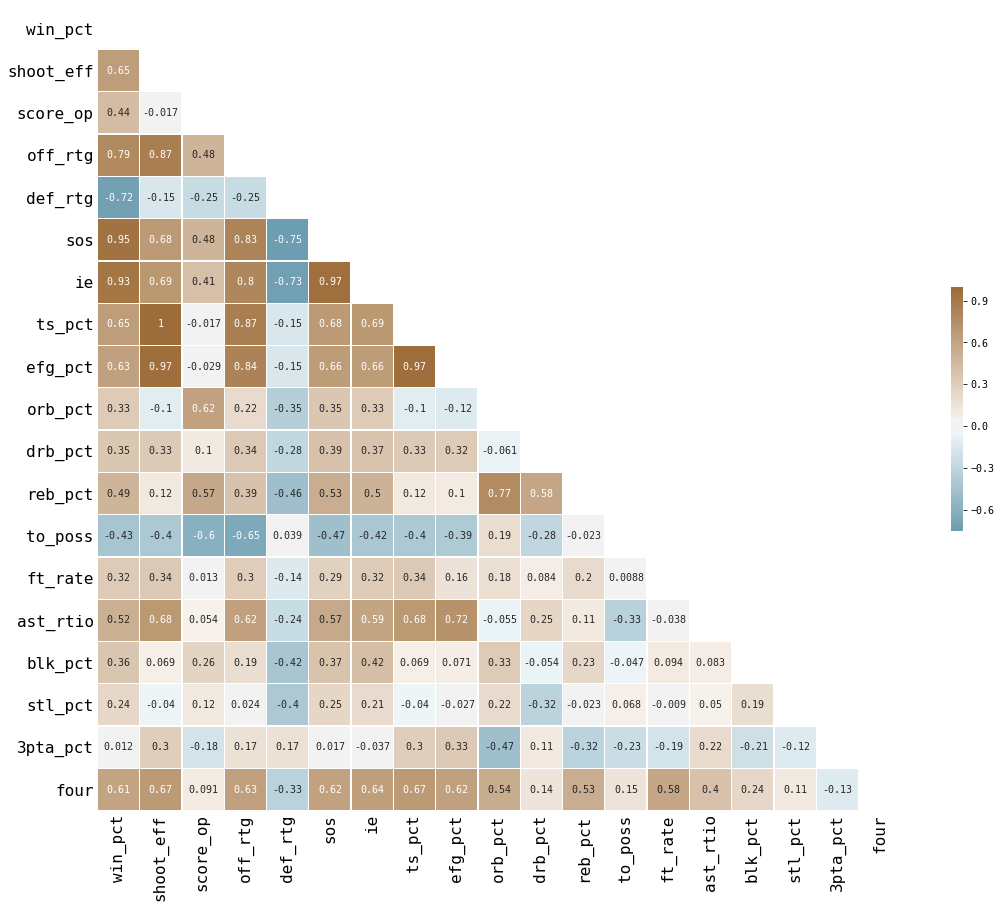

In [27]:
fig = plt.figure(figsize=(18, 18))

# Save the correlation matrix:
matrix = df_avgs[['win_pct', 'shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ie', 'ts_pct', 'efg_pct', 'orb_pct', 'drb_pct', 'reb_pct', 'to_poss', 'ft_rate', 'ast_rtio', 'blk_pct', 'stl_pct', '3pta_pct', 'four']].corr()

# Create mask for the upper triangle:
mask = np.zeros_like(matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Create a custom diverging colormap:
cmap = sns.diverging_palette(225, 45, as_cmap=True)

sns.heatmap(matrix, mask=mask, cmap=cmap, center=0, annot=True, square=True, linewidths=0.25, cbar_kws={'shrink': 0.25})
plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16);

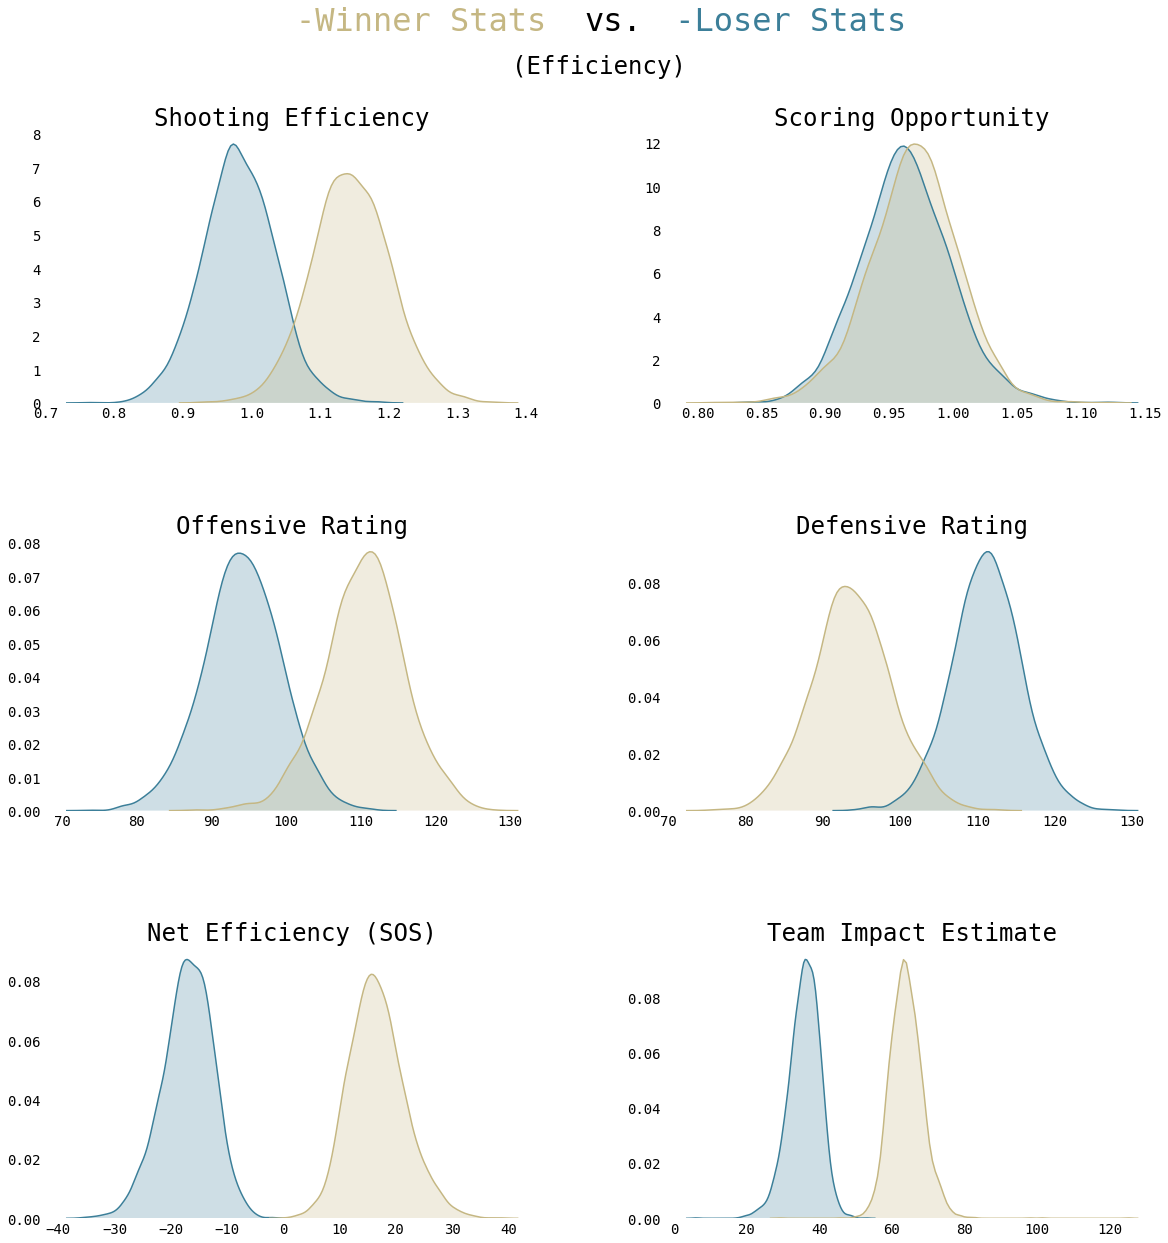

In [28]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 2, wspace=0.25, hspace=0.5)

fig.text(x=0.30, y=0.95, s='-Winner Stats', fontsize=32, color='#c5b783')
fig.text(x=0.50, y=0.95, s='vs.', fontsize=32)
fig.text(x=0.55, y=0.95, s=' -Loser Stats', fontsize=32, color='#3c7f99')
fig.text(x=0.45, y=0.92, s='(Efficiency)', fontsize=24)
    
plt.subplot(grid[0, :1])
sns.kdeplot(df_avgs.Lshoot_eff, shade=True, legend=False, color='#3c7f99')
sns.kdeplot(df_avgs.Wshoot_eff, shade=True, legend=False, color='#c5b783')
plt.title('Shooting Efficiency', fontsize=24)
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(grid[0, 1:])
sns.kdeplot(df_avgs.Lscore_op, shade=True, legend=False, color='#3c7f99')
sns.kdeplot(df_avgs.Wscore_op, shade=True, legend=False, color='#c5b783')
plt.title('Scoring Opportunity', fontsize=24)
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(grid[1, :1])
sns.kdeplot(df_avgs.Loff_rtg, shade=True, legend=False, color='#3c7f99')
sns.kdeplot(df_avgs.Woff_rtg, shade=True, legend=False, color='#c5b783')
plt.title('Offensive Rating', fontsize=24)
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(grid[1, 1:])
sns.kdeplot(df_avgs.Ldef_rtg, shade=True, legend=False, color='#3c7f99')
sns.kdeplot(df_avgs.Wdef_rtg, shade=True, legend=False, color='#c5b783')
plt.title('Defensive Rating', fontsize=24)
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(grid[2, :1])
sns.kdeplot(df_avgs.Lsos, shade=True, legend=False, color='#3c7f99')
sns.kdeplot(df_avgs.Wsos, shade=True, legend=False, color='#c5b783')
plt.title('Net Efficiency (SOS)', fontsize=24)
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(grid[2, 1:])
sns.kdeplot(df_avgs.Lie, shade=True, legend=False, color='#3c7f99')
sns.kdeplot(df_avgs.Wie, shade=True, legend=False, color='#c5b783')
plt.title('Team Impact Estimate', fontsize=24)
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=14);

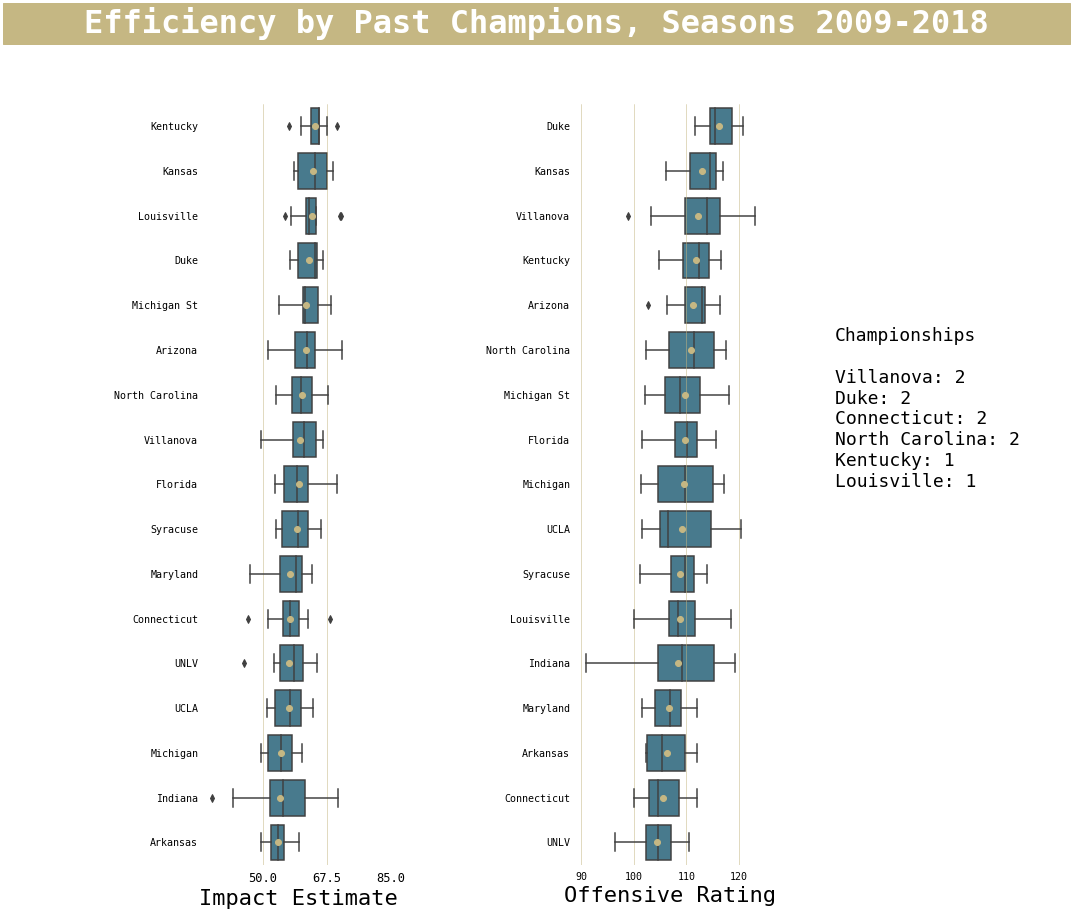

In [29]:
fig, ax = plt.subplots(figsize=(10, 14))
grid = plt.GridSpec(1, 2, wspace=1)
fig.text(x=-0.15, y=0.95, s='    Efficiency by Past Champions, Seasons 2009-2018    ', fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
fig.text(x=1, y=0.5, s='Championships\n\n' + '\n'.join('{}: {}'.format(k, v) for k, v in championships[championships.Season.isin(df_avgs.Season.unique())].WTeamName.value_counts().to_dict().items()), fontsize=18)

plt.subplot(grid[0, :1]).xaxis.grid(which='both', linewidth=0.5, color='#c5b783')
sns.boxplot(y='TeamName', x='ie', data=df_avgs[(df_avgs.Season < 2019) & (df_avgs.TeamName.isin(championships.WTeamName.unique()))], color='#3c7f99', 
            order=df_avgs.ie.groupby(df_avgs[(df_avgs.Season < 2019) & (df_avgs.TeamName.isin(championships.WTeamName.unique()))].TeamName).mean().sort_values(ascending=False).to_frame().index, 
            meanprops=dict(marker='o', markeredgecolor='#c5b783', markerfacecolor='#c5b783'), 
            showmeans=True)
plt.box(False)
plt.xlabel('Impact Estimate', fontsize=22); plt.ylabel('')
plt.xticks([50, 67.5, 85], fontsize=12)

plt.subplot(grid[0, 1:]).xaxis.grid(which='both', linewidth=0.5, color='#c5b783')
sns.boxplot(y='TeamName', x='off_rtg', data=df_avgs[(df_avgs.Season < 2019) & (df_avgs.TeamName.isin(championships.WTeamName.unique()))], color='#3c7f99', 
            order=df_avgs.off_rtg.groupby(df_avgs[(df_avgs.Season < 2019) & (df_avgs.TeamName.isin(championships.WTeamName.unique()))].TeamName).mean().sort_values(ascending=False).to_frame().index, 
            meanprops=dict(marker='o', markeredgecolor='#c5b783', markerfacecolor='#c5b783'), 
            showmeans=True)
plt.box(False)
plt.xlabel('Offensive Rating', fontsize=22); plt.ylabel('');

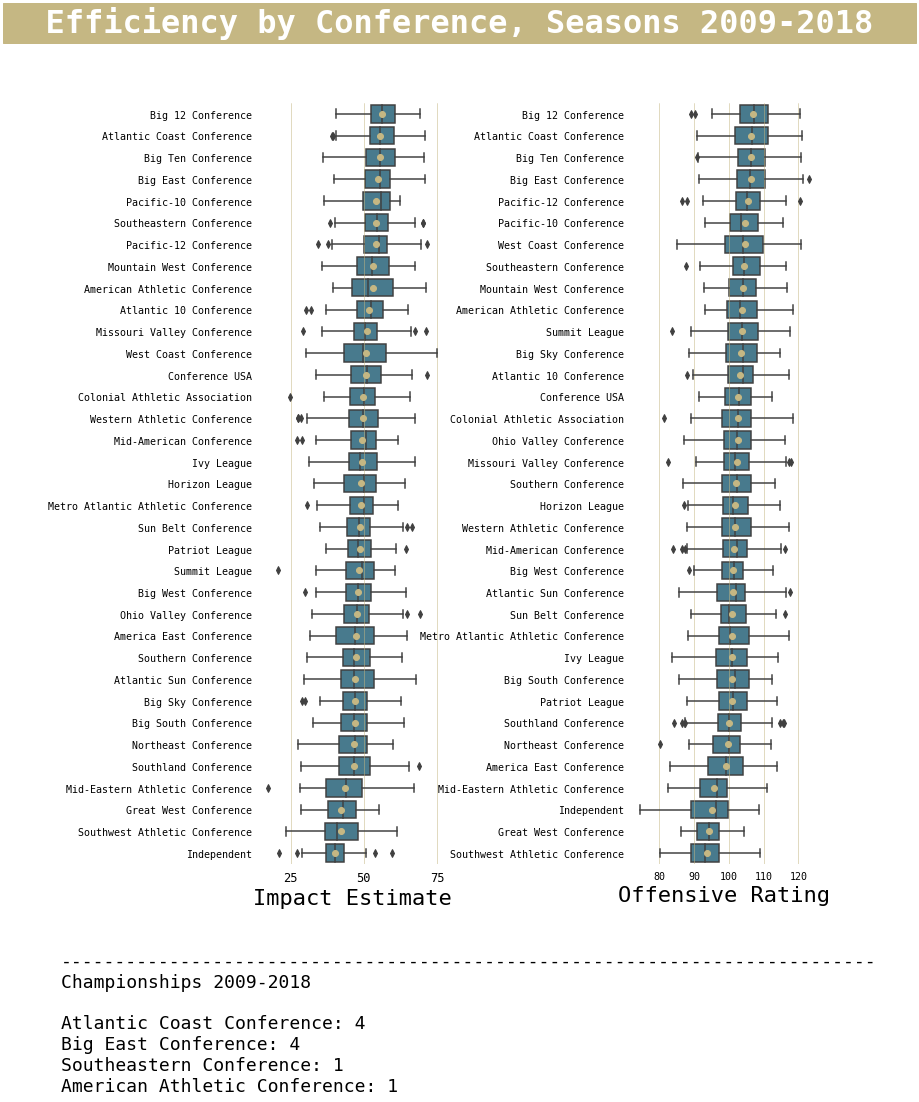

In [30]:
fig, ax = plt.subplots(figsize=(10, 14))
grid = plt.GridSpec(1, 2, wspace=1)
fig.text(x=-0.225, y=0.95, s='  Efficiency by Conference, Seasons 2009-2018  ', fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
fig.text(x=-0.15, y=-0.1, s='-'*75 + '\nChampionships 2009-2018\n\n' + '\n'.join('{}: {}'.format(k, v) for k, v in championships[championships.Season.isin(df_avgs.Season.unique())].WConfName.value_counts().to_dict().items()), fontsize=18)

plt.subplot(grid[0, :1]).xaxis.grid(which='both', linewidth=0.5, color='#c5b783')
sns.boxplot(y='ConfName', x='ie', data=df_avgs[df_avgs.Season < 2019], color='#3c7f99', 
            order=df_avgs.ie.groupby(df_avgs[df_avgs.Season < 2019].ConfName).mean().sort_values(ascending=False).to_frame().index, 
            meanprops=dict(marker='o', markeredgecolor='#c5b783', markerfacecolor='#c5b783'), 
            showmeans=True)
plt.box(False)
plt.xlabel('Impact Estimate', fontsize=22); plt.ylabel('')
plt.xticks([25, 50, 75], fontsize=12)

plt.subplot(grid[0, 1:]).xaxis.grid(which='both', linewidth=0.5, color='#c5b783')
sns.boxplot(y='ConfName', x='off_rtg', data=df_avgs[df_avgs.Season < 2019], color='#3c7f99', 
            order=df_avgs.off_rtg.groupby(df_avgs[df_avgs.Season < 2019].ConfName).mean().sort_values(ascending=False).to_frame().index, 
            meanprops=dict(marker='o', markeredgecolor='#c5b783', markerfacecolor='#c5b783'), 
            showmeans=True)
plt.box(False)
plt.xlabel('Offensive Rating', fontsize=22); plt.ylabel('');

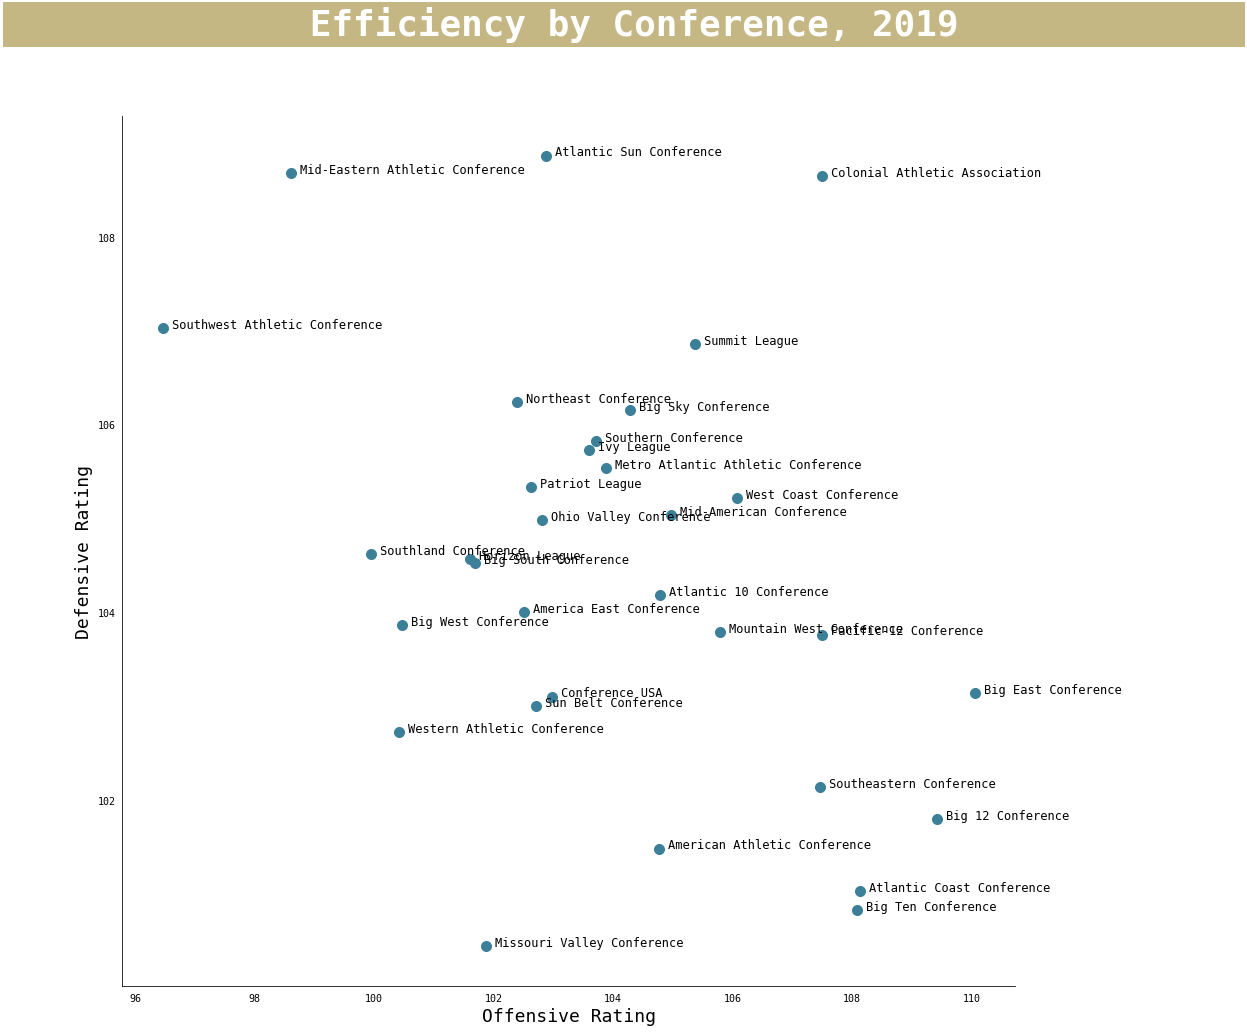

In [31]:
crrnt_seasn = df_avgs[df_avgs.Season == df_avgs.Season.max()]
conf_eff = crrnt_seasn['off_rtg'].groupby(crrnt_seasn.ConfName).mean().to_frame()
conf_eff['def_rtg'] = crrnt_seasn['def_rtg'].groupby(crrnt_seasn.ConfName).mean()
conf_eff.reset_index(inplace=True)

x_coords = conf_eff.off_rtg
y_coords = conf_eff.def_rtg
confs = conf_eff.ConfName

fig, ax = plt.subplots(figsize=(16, 16))
fig.text(x=0.025, y=0.95, s='              Efficiency by Conference, 2019             ', fontsize=36, weight='bold', color='white', backgroundcolor='#c5b783')

for i, conf in enumerate(confs):
    x = x_coords[i]
    y = y_coords[i]
    plt.plot(x, y, marker='o', markersize=10, markeredgecolor='#3c7f99', markerfacecolor='#3c7f99')
    plt.text(x + .15, y, conf, fontsize=12)
    
plt.autoscale(enable=True, axis='both')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Offensive Rating', fontsize=18); plt.ylabel('Defensive Rating', fontsize=18);

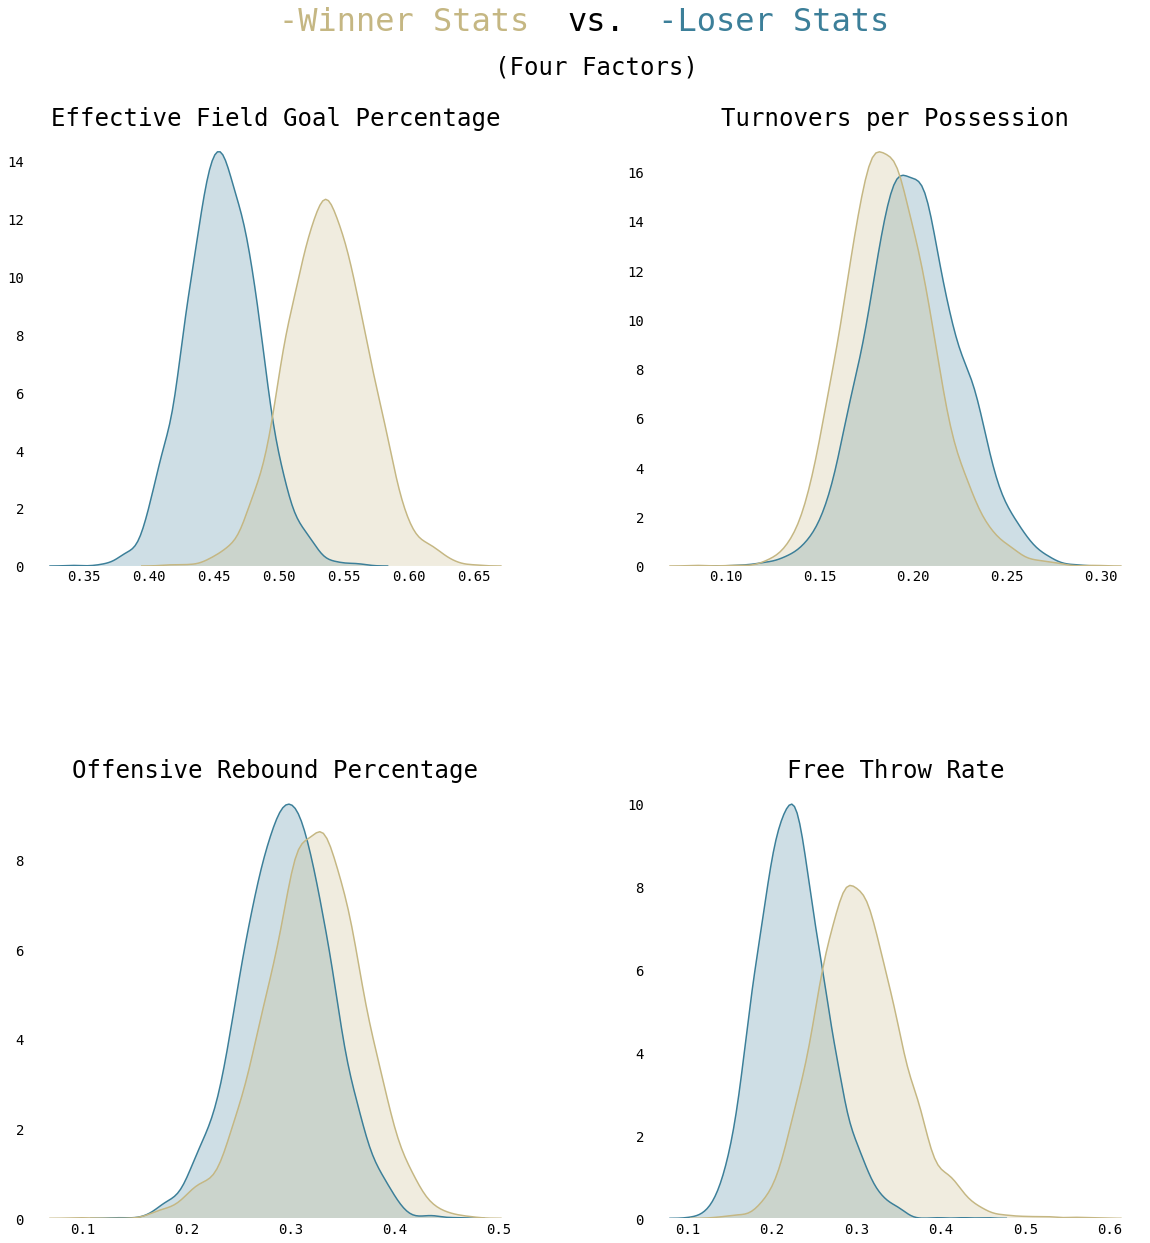

In [32]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(2, 2, wspace=0.25, hspace=0.5)

fig.text(x=0.30, y=0.95, s='-Winner Stats', fontsize=32, color='#c5b783')
fig.text(x=0.50, y=0.95, s='vs.', fontsize=32)
fig.text(x=0.55, y=0.95, s=' -Loser Stats', fontsize=32, color='#3c7f99')
fig.text(x=0.45, y=0.92, s='(Four Factors)', fontsize=24)
    

plt.subplot(grid[0, :1])
sns.kdeplot(df_avgs.Lefg_pct, shade=True, legend=False, color='#3c7f99')
sns.kdeplot(df_avgs.Wefg_pct, shade=True, legend=False, color='#c5b783')
plt.title('Effective Field Goal Percentage', fontsize=24)
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(grid[0, 1:])
sns.kdeplot(df_avgs.Lto_poss, shade=True, legend=False, color='#3c7f99')
sns.kdeplot(df_avgs.Wto_poss, shade=True, legend=False, color='#c5b783')
plt.title('Turnovers per Possession', fontsize=24)
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(grid[1, :1])
sns.kdeplot(df_avgs.Lorb_pct, shade=True, legend=False, color='#3c7f99')
sns.kdeplot(df_avgs.Worb_pct, shade=True, legend=False, color='#c5b783')
plt.title('Offensive Rebound Percentage', fontsize=24)
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(grid[1, 1:])
sns.kdeplot(df_avgs.Lft_rate, shade=True, legend=False, color='#3c7f99')
sns.kdeplot(df_avgs.Wft_rate, shade=True, legend=False, color='#c5b783')
plt.title('Free Throw Rate', fontsize=24)
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=14);

In [33]:
def calc_trendline(x, y, plt):
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r")

[90.05739685]
[31.39778761]
[49.92635001]
[43.24447748]


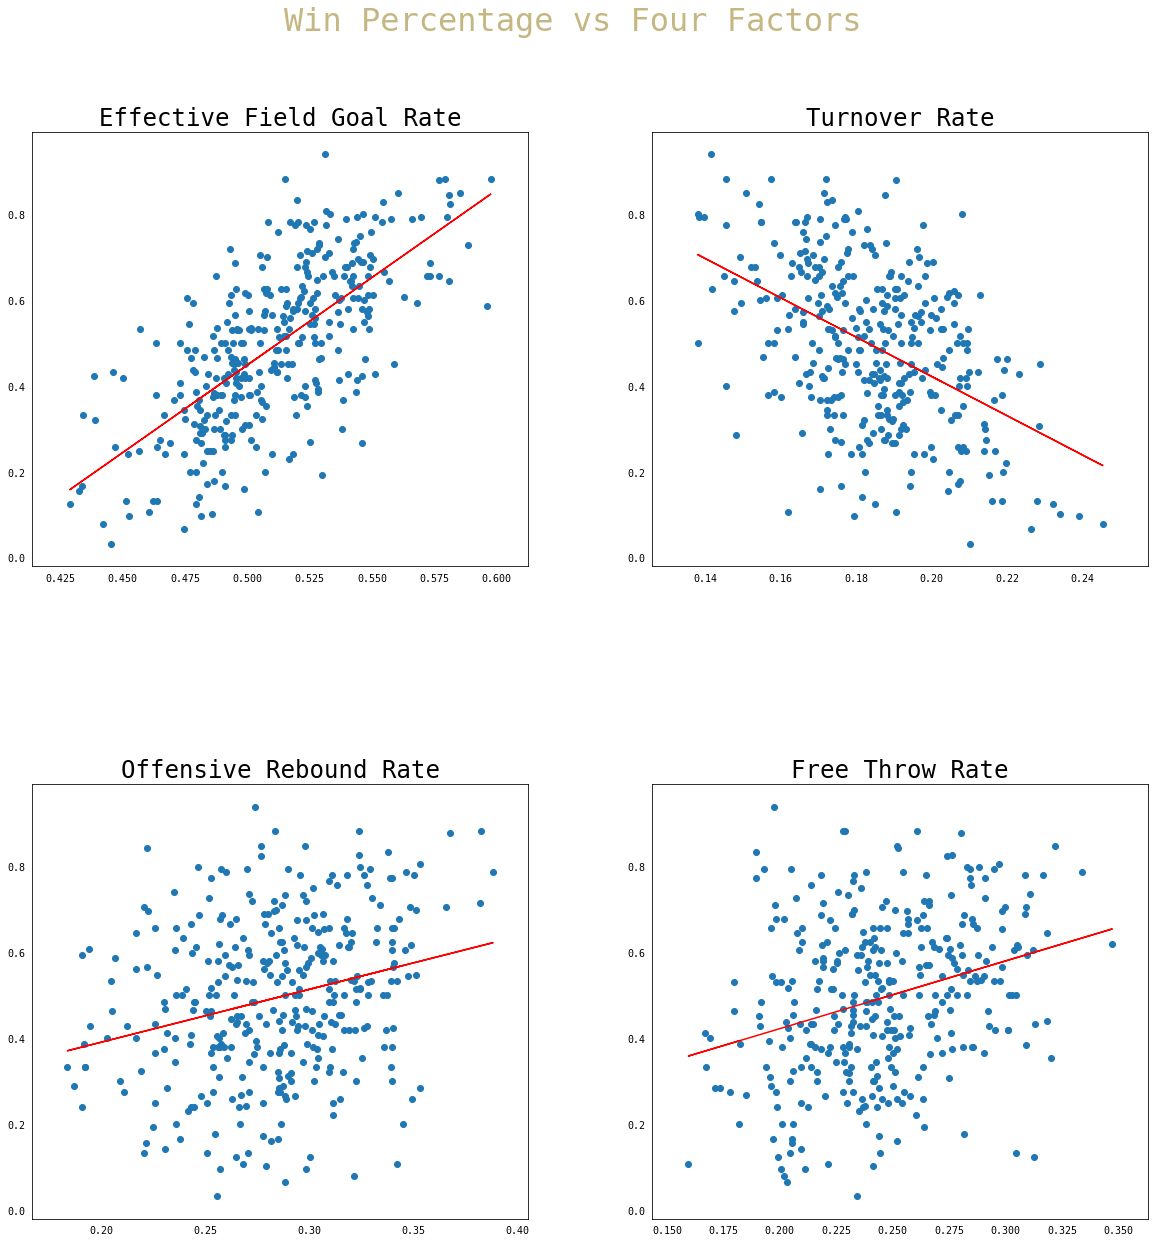

In [34]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(2, 2, wspace=0.25, hspace=0.5)

fig.text(x=.30, y=0.95, s='Win Percentage vs Four Factors', fontsize=32, color='#c5b783')

crrnt_seasn = df_avgs[df_avgs.Season == df_avgs.Season.max()]
y = crrnt_seasn.win_pct
# 'to_poss', 'orb_pct', 'ft_rate',
plt.subplot(grid[0, :1])
x = crrnt_seasn.efg_pct
plt.scatter(x, y, marker='o')
calc_trendline(x, y ,plt)
print(np.correlate(x,y))
plt.title('Effective Field Goal Rate', fontsize=24)

plt.subplot(grid[0, 1:])
x = crrnt_seasn.to_poss
plt.scatter(x, y, marker='o')
calc_trendline(x, y ,plt)
print(np.correlate(x,y))
plt.title('Turnover Rate', fontsize=24)

plt.subplot(grid[1, :1])
x = crrnt_seasn.orb_pct
plt.scatter(x, y, marker='o')
calc_trendline(x, y ,plt)
print(np.correlate(x,y))
plt.title('Offensive Rebound Rate', fontsize=24)

plt.subplot(grid[1, 1:])
x = crrnt_seasn.ft_rate
plt.scatter(x, y, marker='o')
calc_trendline(x, y ,plt)
print(np.correlate(x,y))
plt.title('Free Throw Rate', fontsize=24);

# Prepare Data

In [35]:

df_features = df_avgs[['Season', 'TeamID', 'ConfName', 'shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ie', 'efg_pct', 'to_poss', 'orb_pct', 'ft_rate', 'reb_pct', 'drb_pct', 'ts_pct', 'ast_rtio', 'blk_pct', 'stl_pct', '3pta_pct', 'four']]
df_features.head()

,Season,TeamID,ConfName,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,3pta_pct,four
0,2009,1102,Mountain West Conference,1.085291,0.889878,96.299984,104.587557,-8.287573,45.017838,0.510982,0.227405,0.244868,0.292335,0.475110,0.705352,54.264573,15.029665,8.383859,8.392002,40.301355,0.354068
1,2009,1103,Mid-American Conference,1.046479,0.969046,101.136160,91.695561,9.440599,57.762970,0.484648,0.208949,0.338182,0.268368,0.488979,0.639775,52.323944,13.394015,6.757949,11.494857,39.570508,0.353988
2,2009,1104,Southeastern Conference,1.037844,0.991382,102.678377,100.324007,2.354371,53.199604,0.477437,0.208222,0.384273,0.275692,0.512170,0.640067,51.892178,11.491549,11.439949,9.837355,24.487328,0.361239
3,2009,1105,Southwest Athletic Conference,0.945542,0.947650,88.995102,99.473030,-10.477928,38.370096,0.432951,0.223072,0.308323,0.271259,0.466884,0.625446,47.277077,11.024702,8.004646,11.073513,29.328933,0.331302
4,2009,1106,Southwest Athletic Conference,1.080827,0.968056,104.238372,95.270553,8.967819,60.199487,0.517747,0.205138,0.343423,0.238125,0.495232,0.647042,54.041338,15.055598,11.070469,8.620415,31.429870,0.362786


In [36]:
df_seeds = df_seeds[df_seeds.Season > 2008]
df_features = pd.merge(df_seeds, df_features, how='left', left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'])
df_features['seed'] = pd.Categorical(df_features.seed)
df_dummies = pd.get_dummies(df_features.seed, prefix='seed')
df_features = pd.concat([df_features, df_dummies], axis=1)
df_features.drop(['seed'], inplace=True, axis=1)

In [37]:
df_features['ConfName'] = pd.Categorical(df_features.ConfName)
df_dummies = pd.get_dummies(df_features.ConfName, prefix='conf')
df_features = pd.concat([df_features, df_dummies], axis=1)
df_features.drop(['ConfName'], inplace=True, axis=1)

In [38]:
df_tourney = df_tourney_all[df_tourney_all.Season > 2008]
df_tourney.reset_index(inplace=True, drop=True)
df_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round,Wseed,Lseed,WTeamName,WConfName,LTeamName,LConfName,point_diff
659,2018,136,1211,68,1422,64,N,0,64,4,13,Gonzaga,West Coast Conference,UNC Greensboro,Southern Conference,4
660,2017,138,1211,79,1321,73,N,0,32,1,8,Gonzaga,West Coast Conference,Northwestern,Big Ten Conference,6
661,2014,137,1455,64,1142,37,N,0,64,1,16,Wichita St,Missouri Valley Conference,Cal Poly SLO,Big West Conference,27
662,2011,136,1361,68,1294,50,N,0,64,2,15,San Diego St,Mountain West Conference,N Colorado,Big Sky Conference,18
663,2015,135,1352,81,1316,77,N,0,68,16,16,Robert Morris,Northeast Conference,North Florida,Atlantic Sun Conference,4


In [39]:
# Merge tourney games with tourney winners' season features:
df_winners = pd.merge(left=df_tourney[['Season', 'WTeamID', 'LTeamID']], right=df_features, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df_winners.drop(['TeamID'], inplace=True, axis=1) 
df_winners.dropna(inplace=True)

# Merge tourney games with loser features:
df_losers = pd.merge(left=df_tourney[['Season', 'WTeamID', 'LTeamID']], right=df_features, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df_losers.drop(['TeamID'], inplace=True, axis=1)
df_losers.dropna(inplace=True)

In [40]:
df_winners

,Season,WTeamID,LTeamID,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,3pta_pct,four,seed_1,seed_2,seed_3,seed_4,seed_5,seed_6,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12,seed_13,seed_14,seed_15,seed_16,conf_America East Conference,conf_American Athletic Conference,conf_Atlantic 10 Conference,conf_Atlantic Coast Conference,conf_Atlantic Sun Conference,conf_Big 12 Conference,conf_Big East Conference,conf_Big Sky Conference,conf_Big South Conference,conf_Big Ten Conference,conf_Big West Conference,conf_Colonial Athletic Association,conf_Conference USA,conf_Horizon League,conf_Ivy League,conf_Metro Atlantic Athletic Conference,conf_Mid-American Conference,conf_Mid-Eastern Athletic Conference,conf_Missouri Valley Conference,conf_Mountain West Conference,conf_Northeast Conference,conf_Ohio Valley Conference,conf_Pacific-10 Conference,conf_Pacific-12 Conference,conf_Patriot League,conf_Southeastern Conference,conf_Southern Conference,conf_Southland Conference,conf_Southwest Athletic Conference,conf_Summit League,conf_Sun Belt Conference,conf_West Coast Conference,conf_Western Athletic Conference
0,2016,1437,1234,1.168841,0.974202,113.376280,94.038322,19.337958,64.853809,0.545000,0.163086,0.280623,0.271153,0.496178,0.711733,58.442070,17.132832,9.581786,9.879554,43.470740,0.355569,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015,1211,1234,1.214481,0.993465,120.411697,93.271406,27.140290,71.181492,0.585543,0.163070,0.333712,0.275005,0.526184,0.718655,60.724039,17.643204,8.334005,9.207896,31.993482,0.382978,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2014,1397,1234,1.071839,1.046149,111.793928,96.981035,14.812892,59.227845,0.496147,0.171513,0.391469,0.297351,0.559595,0.727720,53.591953,13.515297,12.238827,8.198675,30.567342,0.364233,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2011,1246,1343,1.122986,1.022036,114.358518,95.259322,19.099196,63.264055,0.525453,0.159160,0.352140,0.272280,0.524317,0.696493,56.149315,13.761497,15.480947,8.162046,31.897490,0.361241,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2017,1323,1343,1.149950,0.998911,114.711634,101.449993,13.261641,57.487482,0.539373,0.138892,0.272751,0.229589,0.481858,0.690965,57.497510,16.938725,9.962461,10.577693,40.757533,0.339461,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2009,1242,1173,1.151348,0.964812,110.557592,94.397150,16.160442,64.273511,0.540209,0.209028,0.369416,0.302553,0.540855,0.712294,57.567395,16.419897,11.579866,9.764411,30.157942,0.387607,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2015,1328,1173,1.066453,0.984204,104.618682,91.598083,13.020600,61.782472,0.494929,0.175623,0.304701,0.248901,0.495498,0.686296,53.322670,13.429795,12.873696,10.111673,33.653118,0.340152,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2016,1393,1173,1.073861,0.998376,106.893272,99.624492,7.268780,54.373555,0.506150,0.183268,0.330689,0.248865,0.490437,0.650186,53.693072,15.295590,11.938570,12.283405,43.309982,0.351744,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2014,1196,1173,1.115646,1.008230,111.722588,91.371523,20.351065,66.568162,0.529672,0.178279,0.347259,0.292256,0.530308,0.713357,55.782307,14.999013,7.960090,11.285736,35.090104,0.369729,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,2017,1455,1173,1.167282,1.011573,117.756247,89.954680,27.801567,71.283491,0.546397,0.159701,0.340392,0.306916,0.548988,0.757584,58.364089,16.658447,11.076665,9.633009,36.464892,0.372600,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [41]:
# Create winner target by subtracting loser data from winner data,
# and assigning a value of 1:
df_winner_diff = (df_winners.iloc[:, 3:] - df_losers.iloc[:, 3:])
df_winner_diff['result'] = 1

# Create loser target by subtracting winner data from loser data,
# and assigning a value of 0:
df_loser_diff = (df_losers.iloc[:, 3:] - df_winners.iloc[:, 3:])
df_loser_diff['result'] = 0

# Concatenate winner data with loser data:
df_model = pd.concat((df_winner_diff, df_loser_diff), axis=0)
df_model.head()

,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,3pta_pct,four,seed_1,seed_2,seed_3,seed_4,seed_5,seed_6,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12,seed_13,seed_14,seed_15,seed_16,conf_America East Conference,conf_American Athletic Conference,conf_Atlantic 10 Conference,conf_Atlantic Coast Conference,conf_Atlantic Sun Conference,conf_Big 12 Conference,conf_Big East Conference,conf_Big Sky Conference,conf_Big South Conference,conf_Big Ten Conference,conf_Big West Conference,conf_Colonial Athletic Association,conf_Conference USA,conf_Horizon League,conf_Ivy League,conf_Metro Atlantic Athletic Conference,conf_Mid-American Conference,conf_Mid-Eastern Athletic Conference,conf_Missouri Valley Conference,conf_Mountain West Conference,conf_Northeast Conference,conf_Ohio Valley Conference,conf_Pacific-10 Conference,conf_Pacific-12 Conference,conf_Patriot League,conf_Southeastern Conference,conf_Southern Conference,conf_Southland Conference,conf_Southwest Athletic Conference,conf_Summit League,conf_Sun Belt Conference,conf_West Coast Conference,conf_Western Athletic Conference,result
0,0.068370,-0.049664,0.959964,-4.941431,5.901395,4.960296,0.028683,0.013700,-0.039523,0.023208,-0.007772,0.023978,3.418522,0.890887,-3.168235,0.145431,8.431379,0.010475,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.154822,-0.027494,13.016279,-2.715999,15.732277,10.949020,0.103998,-0.010895,-0.022360,-0.026423,-0.003114,0.016131,7.741120,2.080226,-4.810704,-0.642013,1.519892,0.030440,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,-0.050490,0.010433,-3.955824,-1.844757,-2.111066,-4.537502,-0.018963,0.013002,0.010926,-0.045686,0.012750,0.014573,-2.524502,-2.450896,-1.794150,-1.986045,3.072105,-0.009002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.001109,0.058079,6.776393,-2.494868,9.271260,5.684892,0.002627,-0.030030,0.040945,-0.006067,0.000894,-0.039157,0.055443,-1.238504,4.531340,-0.797799,0.935096,0.000822,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.018753,0.026318,5.112969,6.294442,-1.181473,-0.213880,0.000175,-0.014250,0.026068,0.044622,-0.020985,-0.068038,0.937644,1.131641,-0.046542,0.070358,-5.646191,0.008415,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [42]:
df_model.dropna(inplace=True)
X = df_model.iloc[:, :-1]
y = df_model.result


# Split the dataframe into 80% training and 20% testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [67]:
def clfy_report(clf, X_train, X_test, y_train, y_test, param_grid, clf_label='clf', cv=10, scale=True):
    """
    Tune classifier hyperparameters and print metrics.
    """
    from yellowbrick.classifier import ClassificationReport


    # Create pipeline steps for scaling and classifying:
    if scale:
        pipe = Pipeline([('scaler', StandardScaler()), (clf_label, clf)])
    else:
        pipe = Pipeline([(clf_label, clf)])
    
    # Instantiate grid search using 10-fold cross validation:
    search = GridSearchCV(pipe, param_grid, cv=10)
    
    # Learn relationship between predictors (basketball/tourney features) and outcome,
    # and the best parameters for defining such:
    search.fit(X_train, y_train)
        
    # Predictions on the test set, new data that haven't been introduced to the model:
    predicted = search.predict(X_test)
    view = X_test.copy()
    view['pred'] = predicted
    view['real'] = y_test
    display(view)
    
    # Predictions as probabilities:
    probabilities = search.predict_proba(X_test)[:, 1]
        
    # Accuracy scores for the training and test sets:
    train_accuracy = search.score(X_train, y_train)
    test_accuracy = search.score(X_test, y_test)

    print('Best Parameters: {}\n'.format(search.best_params_))
    print('Training Accuracy: {:0.2}'.format(train_accuracy))
    print('Test Accuracy: {:0.2}\n'.format(test_accuracy))
    
    # Confusion matrix labels:
    labels = np.array([['true losses','false wins'], ['false losses','true wins']])
    
    # Model evaluation metrics:
    confusion_mtrx = confusion_matrix(y_test, predicted)
    auc = roc_auc_score(y_test, probabilities)
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    logloss = log_loss(y_test, search.predict_proba(X_test))
    
    # Plot all metrics in a grid of subplots:
    fig = plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(2, 4, wspace=0.75, hspace=0.5)
    
    # Top-left plot - confusion matrix:
    plt.subplot(grid[0, :2])
    sns.heatmap(confusion_mtrx, annot=labels, fmt='')
    plt.xlabel('Predicted Games')
    plt.ylabel('Actual Games');
    
    # Top-right plot - ROC curve:
    plt.subplot(grid[0, 2:])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC: {:0.3}'.format(auc));
    
    # Bottom-left plot - support, or true predictions:
    plt.subplot(grid[1, :2])
    sns.countplot(y=predicted, orient='h')
    plt.yticks([1, 0], ('wins', 'losses'))
    plt.ylabel(''), plt.xlabel('Number Predicted');
    
    # Bottom-right plot - classification report:
    plt.subplot(grid[1, 2:])
    visualizer = ClassificationReport(search, classes=['losses', 'wins'])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    g = visualizer.poof();
    
    return search, train_accuracy, test_accuracy, auc, logloss

     shoot_eff  score_op    off_rtg    def_rtg        sos         ie  \
39   -0.007304  0.011564   0.967303   8.468873  -7.501570  -7.117811   
169  -0.056665  0.086589   3.135732   2.690648   0.445085  -1.144919   
575  -0.001368 -0.001426  -0.281066  -5.283943   5.002878   4.607735   
209  -0.120042  0.020138  -9.612888  17.026908 -26.639796 -20.540195   
1     0.154822 -0.027494  13.016279  -2.715999  15.732277  10.949020   
660   0.150555 -0.029661  11.393302 -11.850675  23.243977  19.254190   
658   0.024156  0.047789   7.326064  -3.596130  10.922194   8.283029   
109   0.007819 -0.014004  -0.791459   8.217588  -9.009046  -5.922207   
403   0.005457 -0.005608  -0.001464   3.630628  -3.632092  -1.431648   
479  -0.052567 -0.024675  -8.031927 -10.819156   2.787229   4.692628   
97    0.013240 -0.002357   0.935352   7.421149  -6.485798  -5.503174   
369   0.044654 -0.034477   0.415422  -5.909683   6.325106   7.149143   
218  -0.011616 -0.001418  -1.124985   1.055242  -2.180226  -2.57

,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,3pta_pct,four,seed_1,seed_2,seed_3,seed_4,seed_5,seed_6,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12,seed_13,seed_14,seed_15,seed_16,conf_America East Conference,conf_American Athletic Conference,conf_Atlantic 10 Conference,conf_Atlantic Coast Conference,conf_Atlantic Sun Conference,conf_Big 12 Conference,conf_Big East Conference,conf_Big Sky Conference,conf_Big South Conference,conf_Big Ten Conference,conf_Big West Conference,conf_Colonial Athletic Association,conf_Conference USA,conf_Horizon League,conf_Ivy League,conf_Metro Atlantic Athletic Conference,conf_Mid-American Conference,conf_Mid-Eastern Athletic Conference,conf_Missouri Valley Conference,conf_Mountain West Conference,conf_Northeast Conference,conf_Ohio Valley Conference,conf_Pacific-10 Conference,conf_Pacific-12 Conference,conf_Patriot League,conf_Southeastern Conference,conf_Southern Conference,conf_Southland Conference,conf_Southwest Athletic Conference,conf_Summit League,conf_Sun Belt Conference,conf_West Coast Conference,conf_Western Athletic Conference,pred,real
203,-0.038807,0.020135,-1.776894,0.426283,-2.203177,2.888893,-0.020260,0.018046,0.062354,0.045767,0.011152,-0.040049,-1.940369,-0.175967,3.491687,0.987380,0.436978,0.015743,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
489,0.064551,0.019006,8.355846,0.587807,7.768039,7.116547,0.032837,0.014067,0.080601,-0.026385,0.018536,-0.043528,3.227540,2.390482,3.181507,2.354131,0.064626,0.028814,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
366,-0.020204,-0.044770,-7.344436,7.853127,-15.197564,-13.563701,0.000682,0.016647,-0.061911,-0.025006,-0.006142,0.049626,-1.010197,1.343251,-14.437194,-1.042993,15.030142,-0.011699,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
594,0.033441,-0.025387,1.588209,3.401153,-1.812944,-0.433357,0.022881,0.030979,0.016758,-0.014913,-0.013110,-0.042979,1.672053,1.011971,-0.954056,2.650784,2.329337,0.018012,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
326,-0.089265,-0.029725,-12.171321,-8.670131,-3.501190,4.913873,-0.037208,0.042398,0.007083,-0.031154,-0.036152,-0.079388,-4.463268,0.155490,4.516809,5.321298,-5.234184,-0.007540,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
219,0.013721,-0.058871,-5.280730,5.815594,-11.096324,-6.641067,-0.007854,0.000343,-0.089550,0.064103,-0.087472,-0.085395,0.686046,-2.843059,3.372333,1.404479,-0.126829,-0.011351,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
256,-0.066952,0.045399,-2.642833,8.456841,-11.099673,-13.326271,-0.037061,-0.041287,-0.044467,-0.008237,-0.030506,-0.016544,-3.347623,-3.435890,-3.929025,1.909401,11.161538,-0.035275,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
98,0.045032,-0.012501,3.273944,2.225901,1.048043,-3.341304,0.030708,-0.015377,-0.057189,-0.042001,-0.032294,-0.007398,2.251578,2.843851,-3.655757,2.163804,8.906120,-0.009299,0.0,0.

Best Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2'}

Training Accuracy: 0.73
Test Accuracy: 0.71



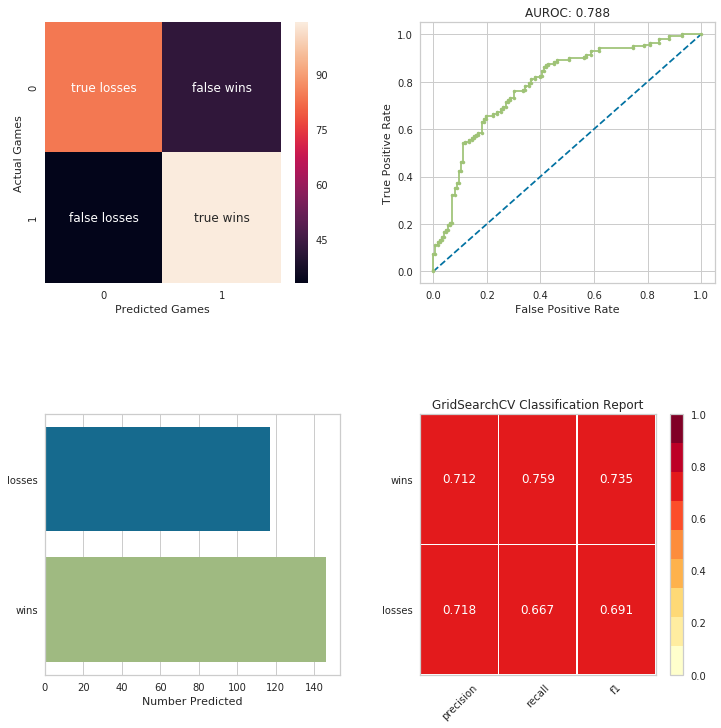

In [65]:
from sklearn.linear_model import LogisticRegression

# Tune Logistic Regression for optimal regularization strength
# and regularization method (penalty):
lr_clf = LogisticRegression(random_state=32)
lr_param_grid = {
    'clf__C': np.logspace(start=-10, stop=10, num=21),
    'clf__penalty': ['l1', 'l2']
}

lr_search, train_accuracy, test_accuracy, auc, logloss = clfy_report(
    lr_clf, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    lr_param_grid, 
    cv=10, 
    scale=True
)

In [45]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier

In [98]:
def model(x):
    def twoLayerFeedForward():
        clf = Sequential()
        clf.add(Dense(68, activation='relu', input_dim=67))
        clf.add(Dense(2, activation='softmax'))
        clf.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=["accuracy"])
        return clf
    return twoLayerFeedForward

In [100]:
clf = KerasClassifier(model(X_train), epochs=100, batch_size=1, verbose=0)

# lr_param_grid = {
#     'epochs': [10, 50, 100, 500]
# }

param_grid = dict(epochs=[50,100,500, 1000])
grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
grid_result.fit(X_train, y_train)

# Predictions on the test set, new data that haven't been introduced to the model:
predicted = grid_result.predict(X_test)
view = X_test.copy()
view['pred'] = predicted
view['real'] = y_test

train_accuracy = grid_result.score(X_train, y_train)
test_accuracy = grid_result.score(X_test, y_test)

print('Best Parameters: {}\n'.format(grid_result.best_params_))
print('Training Accuracy: {:0.2}'.format(train_accuracy))
print('Test Accuracy: {:0.2}\n'.format(test_accuracy))

Best Parameters: {'epochs': 500}

Training Accuracy: 0.9
Test Accuracy: 0.69

